**Chapter 15 – Autoencoders**

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [3]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

自动编码器是能够在无须任何监督（例如，训练数据集没有任何标记）的情况下学习有效表示输入数据（称为编码）的人工神经网络。这种编码通常比输入数据的维度低得多，使得自动编码可以用来降低维度（见第8章）。更重要的是，自动编码器作为强大的特征检测器，可以用于深层神经网络的无监督训练（如第11章所讨论的）。最后，它们能够生产与训练数据非常相似的新数据；这被称为生成模型。例如，使用面部图片训练自动编码器，然后它可以生成新的面部图片。

与记忆试验中的围棋选手一样，自动编码器查看输入，将它们转化为有效的内部表示，然后输出一些看起来和输入很像的东西。一个自动编码器总是由两部分组成：第一部分是将输入转化为内部表示的编码器（或者称为识别网络），第二部分是将内部表示转换为输出的解码器（或者称为生成网络），见图15-1。

<img src='images\autoencoders\The chess memory experiment (left) and a simple autoencoder (right).png'>

图15-1：国际象棋记忆实验（左）和一个简单的自动编码器（右）

自动编码器通常和多层感知器（MLP，参见第10章）具有相同的架构，不同之处在于自动编码器的输出层的神经元数量必须等于输入层的数量。在这个例子中，只有一个由两个神经元（编码器）组成的隐藏层，以及一个由三个神经元（解码器）组成的输出层。输出通常被称为重建，因为自动编码器尝试重建输入，并且成本函数包含重建损失，当重建与输入不同时，该损失会惩罚模型。

因为内部表示的维度低于输入数据（它是2D而不是3D），因此自动编码器不完整。不完整的自动编码器不能简单地复制输入到编码，但是它必须找到一种输出其输入副本的方法。它被强制学习输入数据中最重要的功能（并删除不重要的功能）。让我们看看如何实现一个用来降低维度的非常简单的不完整自动编码器。

## 使用不完整的线性自动编码器实现PCA

如果自动编码器仅使用线性激活，并且成本函数是均方误差（MSE），则表示它可以用来实现主要组件分析（见第8章）。

以下代码构建了一个简单的线性自动编码器，用于执行PCA，将3D数据集投影为2D：

Build 3D dataset:

In [4]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

Normalize the data:

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

Now let's build the Autoencoder...

Note: instead of using the `fully_connected()` function from the `tensorflow.contrib.layers` module (as in the book), we now use the `dense()` function from the `tf.layers` module, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same.

The main differences relevant to this chapter are:
* the `scope` parameter was renamed to `name`, and the `_fn` suffix was removed in all the parameters that had it (for example the `activation_fn` parameter was renamed to `activation`).
* the `weights` parameter was renamed to `kernel` and the weights variable is now named `"kernel"` rather than `"weights"`,
* the bias variable is now named `"bias"` rather than `"biases"`,
* the default activation is `None` instead of `tf.nn.relu`

In [6]:
import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [7]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

与以前章节所构建的MLP相比，这段代码并没有多大的不同。需要注意的有两点：
* 输出的数量等于输入的数量。
* 为了执行简单的PCA，我们设置activation_fn=None（即，所有的神经元是线性的），并且成本函数是MSE。很快我们就会看到更加复杂的自动编码器。 

现在让我们来加载数据集，在训练集上训练模型，并使用该模型来对测试集进行编码（即，将其投影为2D数据）：

Saving figure linear_autoencoder_pca_plot


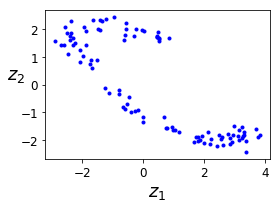

In [8]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
save_fig("linear_autoencoder_pca_plot")
plt.show()

图15-2显示了原始的3D数据集（左侧）和自动编码器隐藏层的输出（即编码层，如图右侧所示）。可以看到，自动编码器找到了最好的2D平台来展现数据，尽可能多地保留数据的差异性（正如PCA一样）。

<img src='images/autoencoders/PCA performed by an undercomplete linear autoencoder.png' >

图15-2：不完整的线性自动编码器实现的PCA

## 栈式自动编码器 Stacked Autoencoders

与我们之前讨论的其他神经网络一样，自动编码器可以有多个隐藏层。在这种情况下，它被称为栈式自动编码器（或者深度自动编码器）。增加更多的层帮助自动编码器学习更加复杂的编码。然而，需要小心的是，不要让自动编码器变得太强大。想象一下，编码器强大到只是学习将每个输入映射到任意单个数字上（解码器学习翻转映射）。显然，这样的自动编码器将完美地重建训练数据，但是在这个过程中没有任何有效的数据表示（并且不可能推广到新的实例）。

栈式自动编码器的结构通常对称于中央隐藏层（编码层）。为了简单起见，它看起来像一个三明治。例如，一个MNIST的自动编码器（见第3章）可能有784个输入，随后是一个有300个神经元的隐藏层，然后是一个有150个神经元的中央隐藏层，然后是一个有300个神经元的隐藏层，最后是一个有784个神经元的输出层。这个栈式自动编码器如图15-3所示。

<img src='images\autoencoders\Stacked autoencoder.png' >

### TensorFlow实现

Let's use MNIST:

In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


###  Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders). We will use ELU activation, He initialization and L2 regularization.

可以像实现一个常规的深度MLP一样实现一个栈式自动编码器。特别是，可以使用我们在第11章训练深度网络的技术实现。例如，以下代码使用He初始化，ELU激活函数，以及正则化构建了一个MNIST栈式自动编码器。除了没有标签外（没有y），代码看起来非常熟悉：

Note: since the `tf.layers.dense()` function is incompatible with `tf.contrib.layers.arg_scope()` (which is used in the book), we now use python's `functools.partial()` function instead. It makes it easy to create a `my_dense_layer()` function that just calls `tf.layers.dense()` with the desired parameters automatically set (unless they are overridden when calling `my_dense_layer()`).

In [10]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

Now let's train it! Note that we don't feed target values (`y_batch` is not used). This is unsupervised training.

In [11]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   # not shown
        print("\r{}".format(epoch), "Train MSE:", loss_train)           # not shown
        saver.save(sess, "./my_model_all_layers.ckpt")                  # not shown

0 Train MSE: 0.020329092
1 Train MSE: 0.0114075765
2 Train MSE: 0.01021888
3 Train MSE: 0.009900079
4 Train MSE: 0.010373402


MNIST栈式自动编码器。除了没有标签外（没有y），代码看起来非常熟悉：

This function loads the model, evaluates it on the test set (it measures the reconstruction error), then it displays the original image and its reconstruction:

In [12]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt
Saving figure reconstruction_ploat


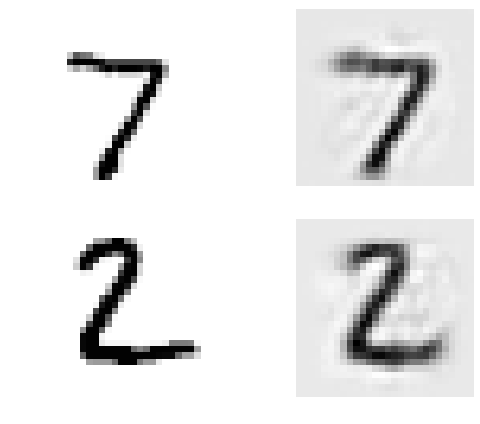

In [13]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")
save_fig("reconstruction_ploat")

### 权重绑定

当自动编码器和我们刚刚构建的那样严格对称时，一种常见的技术是将解码层的权重和编码层的权重联系起来。这种方式将模型的权重减半，提高训练速度，`限制了过度配置的风险`。具体而言，如果自动编码器总共有N层（输入层不计算在内），WL代码第L层的连接权重（例如，第一层是输入层，第N/2层是编码层，第N层是输出层），然后解码层的权重可以简单地定义为：WN-L+1= （其中，L=1，2，…N/2，）。

不幸的是，使用TensorFlow的fully_connected（）函数实现权重绑定有点复杂；实际上，手动定义这些层更加容易一点。代码最终显得更加冗长：

It is common to tie the weights of the encoder and the decoder (`weights_decoder = tf.transpose(weights_encoder)`). Unfortunately this makes it impossible (or very tricky) to use the `tf.layers.dense()` function, so we need to build the Autoencoder manually:

In [14]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [15]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

这些代码很简单，但是有几个重要事情需要注意：
* 第一，weights3和weights4不是变量，它们分别是weights2和weights1的转置（它们被“绑定”在一起）。
* 第二，因为它们不是变量，所以没有必要进行正则化：只正则化weights1和weights2。
* 第三，偏置项从来不会被绑定，也不会被正则化。

#### 一次训练一个自动编码器

相比于像我们这样一次训练整个栈式自动编码器，一次训练一个单独的自动编码器会快很多，然后将它们堆叠为一个栈式自动编码器（因此而得名），如图15-4所示。这种方法对深层自动编码器尤其有用。

<img src='images/autoencoders/Training one autoencoder at a time.png' >

图15-4：一次训练一个自动编码器

In [18]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [19]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Train MSE: 0.018551283
1 Train MSE: 0.018578433
2 Train MSE: 0.019342232
39% Train MSE: 0.019147895
0 Train MSE: 0.004186158
1 Train MSE: 0.00433809
2 Train MSE: 0.0046690544
3 Train MSE: 0.004427336


Finally, we can create a Stacked Autoencoder by simply reusing the weights and biases from the Autoencoders we just trained:

In [20]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

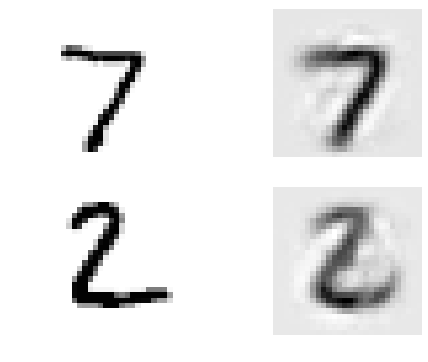

In [21]:
show_reconstructed_digits(X, outputs)

在训练的第一阶段，第一个自动编码器学习重现输入。在第二阶段，第二个自动编码器学习重建第一个自动编码器隐藏层的输出。最终，用这些所有的自动编码器构建了一个大三明治，如图15-4所示（即，首先堆叠各个自动编码器的隐藏层，然后输出层将其顺序反转）。这样就得到了最终的栈式自动编码器。用这种方式，可以轻松地训练更多的自动编码器，来构建一个非常深层的栈式自动编码器。

为了实现这种多阶段训练算法，最简单的方法是对每个阶段使用不同的TensorFlow图，只需通过它来运行训练集并捕获隐藏层的输出。该输出随后作为下一个自动编码器的训练集。一旦用这种方式对所有的自动编码器都进行了训练，只需复制每个自动编码器的权重和偏置系数，并使用它们构建栈式自动编码器。实现方式非常简单，不在这里赘述，请查看Jupyter笔记本里面的代码（https://github.com/ageron/handson-ml） 作为实例。

另外一种途径是使用一个包含整个栈式自动编码器的单个图表，再加上一些为了执行每个训练阶段的额外操作，如图15-5所示。

<img src='images/autoencoders/A single graph to train a stacked autoencoder.png' >

图15-5：训练栈式自动编码器的单个图表

这里需要一点解释：
* 图表的中间列是完全栈式自动编码器。这部分可以在训练后使用。
* 左列是第一阶段训练需要的一系列操作。它创造了一个绕过第二个和第三个隐藏层的输出层。这个输出层和栈式自动编码器**分享相同的权重和偏差系数**。在其之上是训练操作，旨在使得输出尽可能地接近输入。因此，该阶段将为第一个隐藏层和输出层（即第一个自动编码器）训练权重和偏差系数。
* 右列是第二阶段训练需要的一系列操作。其训练操作旨在使得第二个隐藏层的输出尽可能与第一个隐藏层的输出相似。注意，**必须在运行第二阶段时冻结第一隐藏层**。这个阶段将训练第二个和第三个隐藏层（即第二个自动编码器）的权重和偏差系数。

```python
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1
```

第一阶段很简单：创造了一个忽略第二个和第三个隐藏层的输出层，然后构建训练操作来最小化输入和输出之间的距离（加上一些正则化）。 

第二阶段增加了最小化隐藏层3和隐藏层1输出之间的距离所需要的操作（也有一些正则化）。更重要的是，我们为minimize（）方法提供了可训练的变量列表，确保忽略weights1和biases1；以便在第二阶段有效地冻结隐藏层1。  

在执行阶段，需要做的所有事情是在第一阶段训练操作数次，然后执行第二阶段训练操作更多次。

*因为在第二阶段，隐藏层1被冻结，所以对于任意给定的训练实例它的输出总是相同的。为了避免需要在每个单独的时间点重新计算隐藏层1的输出，可以在第一阶段结束的时候为整个训练集计算它，然后直接在第二阶段馈送隐藏层1的输出缓存。这将有很多的性能提升。*

#### Training one Autoencoder at a time in a single graph

In [37]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [38]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

In [39]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [40]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.008275491
1 Train MSE: 0.007927759
2 Train MSE: 0.0077320114
3 Train MSE: 0.007602796
Training phase #2
0 Train MSE: 0.19699986
1 Train MSE: 0.0059469314
2 Train MSE: 0.0026474535
3 Train MSE: 0.0020872727
Test MSE: 0.009720687


#### 重建可视化

保证自动编码器被合适训练的一种方法是比较输入和输出。它们必须相当相似，差异应该是一些不重要的细节。我们来绘制两个随机数字及其重建：

#### Cache the frozen layer outputs

In [41]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 %Train MSE: 0.008117558
1 Train MSE: 0.007595798
2 Train MSE: 0.007454363
3 Train MSE: 0.0077533526
Training phase #2
0 Train MSE: 0.078076646
1 Train MSE: 0.004299964
2 Train MSE: 0.0023144884
3 Train MSE: 0.0019754742
Test MSE: 0.009669314


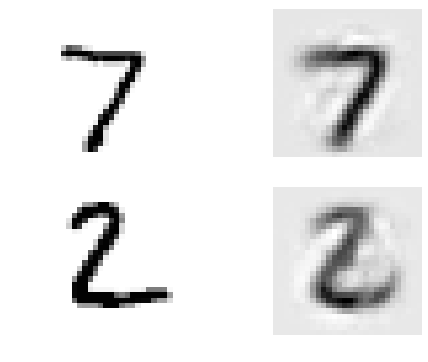

In [33]:
show_reconstructed_digits(X, outputs)

图15-6：原始数字（左）和它们的重建（右）

看起来十分相似。所以自动编码器已经学会了重现其输入，但是它是否学会了有用的特征？让我们来看看。

### 特征可视化

一旦你的自动编码器学会了某些特征，你可能想看看它们。有各种技术可以满足你的愿望。其中，最简单的技术是考虑隐藏层的每个神经元，然后找到激活它最多的训练实例。该技术对顶层的隐藏层尤其有用，因为它们经常捕获相对大的特征，可以容易地从一组包含它们的训练实例中发现。例如，如果一个神经元在看到图片中有猫时被强烈激活，那么很明显激活它的照片大多数都包含猫。然而，对于比较低的隐藏层，该技术就不是很奏效，因为特征相对比较小而且更抽象，所以通常很难准确地了解神经元是如何被激活的。

我们来看看另一种技术。对于第一个隐藏层的每个神经元，可以创建一个图像，其中每一个像素的强度代表了连接到给定神经元的权重。例如，如下代码展示了第一个隐藏层的5个神经元学到的特征：

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt
Saving figure extracted_features_plot


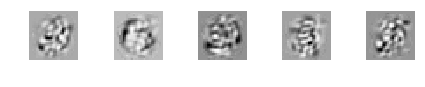

In [42]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

save_fig("extracted_features_plot") # not shown
plt.show()                          # not shown

图15-7：第一个隐藏层的神经元学习到的特征

前四个特征对应于小块特征，第五个特征在寻找垂直笔画（注意，这些特征来自于后面将要讨论的堆叠去噪自动编码器）。

另外一种技术是向自动编码器馈送随机输入图像，测量你感兴趣的神经元的激活，然后执行反向传播，以使得神经元激活更多的方式调整输入图像。如果迭代多次（性能逐渐上升），图像逐渐变为令神经元兴奋的图像。这是一种非常有用的技术来可视化神经元寻找的输入类型。

最终，如果使用自动编码器来执行无监督的预训练，例如分类器。一个简单验证自动编码器学习到的特征是否有用的方法是测量分类器的性能。

### 使用堆叠的自动编码器进行无监控的预训练

正如我们在第11章所讨论的，如果正在执行一个复杂的监督任务，但是没有足够多的已标记训练数据，解决方案之一是找到一个执行类似任务的神经网络，然后重用它的底层。这样就可以使用较少的训练数据来训练高性能模型，因为你的神经网络不用学习所有的低层特征；它将重用现有网络的特征探测器。

类似地，如果你有一个大数据集，但是大部分数据都没有被标记，可以首先使用所有数据训练一个堆叠的自动编码器，然后重用较低层来为你的实际任务创建一个神经网络，并使用已标记的数据来训练它。例如，图15-8显示了如何使用一个堆叠的自动编码器对分类神经网络进行无监督的预训练。如前所述，堆叠的自动编码器自身通常一次训练一个自动编码器。当训练分类器时，如果你实在没有太多的已标记训练数据，则可能需要冻结预训练层（至少是较低层）。

*这种情况很普遍，因为构建一个大的未标记的数据集通常比较容易（例如，一个简单的脚本可以从网络上下载数百万张图片），但是可靠的标记它们只能由人类完成（例如，将图片分为可爱和不可爱）。标记实例耗时而且昂贵，因此只有数千个已标记实例的情况非常普遍。*

<img src='images/autoencoders/Unsupervised pretraining using autoencoders.png' >

图15-8：使用自动编码器进行无监督的预训练

正如我们之前讨论的，2006年Geoffrey Hinton等人的发现：深度神经网络可以被无监督的方式预处理，是触发目前深度学习海啸的因素之一。他们使用了限制性的Boltzmann机器来研究它（见附录E），但是在2007年，Yoshua Bengio等人的研究显示自动编码器也可以工作得一样好。

TensorFlow的实现相当简单：只需要用所有的训练数据训练一个自动编码器，然后复用它的编码层创建一个新的神经网络（更多关于如何复用预训练层的细节，请参见第11章，或者查看Jupyter笔记本中的代码示例）。

至此，为了强制自动编码器学习有用的特征，我们限制了编码层的大小，使其不够完整。实际上我们可以使用一些其他类型的限制来得到一个完整的编码器，包括允许编码层和输入的大小一致，或者更大。我们下面来看一看这其中的一些方法。

Let's create a small neural network for MNIST classification:

In [43]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

Regular training (without pretraining):

In [44]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.94666666 Test accuracy: 0.9265
1 Train accuracy: 0.96666664 Test accuracy: 0.946
2 Train accuracy: 0.97333336 Test accuracy: 0.9442
3 Train accuracy: 0.97333336 Test accuracy: 0.9397


Now reusing the first two layers of the autoencoder we pretrained:

In [45]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
0 Train accuracy: 0.92	Test accuracy: 0.9264
1 Train accuracy: 0.9533333	Test accuracy: 0.9169
2 Train accuracy: 0.9533333	Test accuracy: 0.948
3 Train accuracy: 0.99333334	Test accuracy: 0.9489


### 去噪自动编码器 Stacked denoising Autoencoder

另一种强制自动编码器学习有用特征的方法是在输入中增加噪音，训练它以恢复原始的无噪音输入。这种方法阻止了自动编码器简单地复制其输入到输出，最终必须找到数据中的模式。

自20世纪80年代以来，这种使用自动编码器去除噪音的方式就一直存在（例如，Yann LeCun硕士1987年发表的论文就已提到该自动编码器）。2008年，Pascal Vincent等人发表的论文表明，自动编码器也可以用于特征提取。2010年，Vincent等人的论文介绍了堆叠的去噪自动编码器。

噪音可以是添加到输入中的纯高斯噪音，或者是随机打断输入的噪音，如dropout（第11章介绍的）。图15-9显示了上面的两种方法。

<img src='images/autoencoders/Denoising autoencoders, with Gaussian noise (left) or dropout (right).png' >

图15-9：去噪自动编码器，高斯噪音（左）或dropout（右）

Note: the book uses `tf.contrib.layers.dropout()` rather than `tf.layers.dropout()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dropout()`, because anything in the contrib module may change or be deleted without notice. The `tf.layers.dropout()` function is almost identical to the `tf.contrib.layers.dropout()` function, except for a few minor differences. Most importantly:
* you must specify the dropout rate (`rate`) rather than the keep probability (`keep_prob`), where `rate` is simply equal to `1 - keep_prob`,
* the `is_training` parameter is renamed to `training`.

在TensorFlow实现去噪自动编码器不是很难。让我们从高斯噪音开始。除了为输入增加噪音和根据原始输入计算重建损坏之外，它和训练常规自动编码器很相似：

Using Gaussian noise:

In [46]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [47]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

**因为X向量只在构建阶段定义，所以不能预知添加到X向量的噪音的向量**。我们不能调用X.get_shape（），因为这将只返回部分定义的X（[None，n_inputs]）向量，而random_normal（）返回一个完整定义的向量，所以它将引发异常。相反，我们调用tf.shape（X），它创建了一个在运行时返回该点完全定义的X向量的操作。

In [48]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [49]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.044186756
1 Train MSE: 0.043341257
2 %Train MSE: 0.042749457
3 Train MSE: 0.04138295
4 Train MSE: 0.041432336
59% Train MSE: 0.041583534
6 Train MSE: 0.040199198
7 Train MSE: 0.040725287
8 Train MSE: 0.040795565
9 Train MSE: 0.038627468


Using dropout:

In [50]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [51]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [52]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

在训练期间，必须使用feed_dict设置is_training的值为True（如第11章所解释的）：

In [53]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.027326608
1 Train MSE: 0.025020054
29% Train MSE: 0.022891767
3 Train MSE: 0.022857895
4 Train MSE: 0.02462086
5 Train MSE: 0.023922253
6 Train MSE: 0.02453716
7 Train MSE: 0.022234337
8 Train MSE: 0.023171421
9 %Train MSE: 0.02333467


在测试期间没有必要设置is_training为False，因为调用placeholder_with_default（）函数时我们设置其为默认值。

### 稀疏自动编码器 Sparse Autoencoder

另一种导致良好特征提取的约束是稀疏性：通过在成本函数中增加适当的条件，推动自动编码器减小编码层中活动神经元的数量。例如，可能使得编码层只有平均5%的显著激活神经元。这迫使自动编码器使用少量激活神经元的组合来表示输入。结果，编码层的每个神经元都最终代表一个有用特征（如果你每个月只能说几个单词，那么你可能会尝试让它们变得有意义）。

为了有利于稀疏性模型，必须首先测量每个训练迭代编码层的实际稀疏度。我们通过计算整个训练批次中编码层每个神经元的平均激活程度来实现。批次的尺寸不能太小，否则不能准确计算平均值。

一旦得到了每个神经元的平均激活度，我们希望通过给成本函数添加稀疏性损失以削弱过度激活的神经元。例如，如果测量得到一个神经元的平均激活度是0.3，但是目标稀疏度是0.1，则必须削弱其激活度。一种简单的方法是通过给成本函数增加平方误差 $（0.3–0.1）^2$，但是实际上更好的方法是使用Kullback-Leibler散度（第4章简要讨论过），如图15-10所示，它比均方误差具有更强的梯度。

给定两个离散概率分布P和Q，可以使用公式15-1计算该分布之间的KL散度，表示为DKL（P||Q）。

Saving figure sparsity_loss_plot


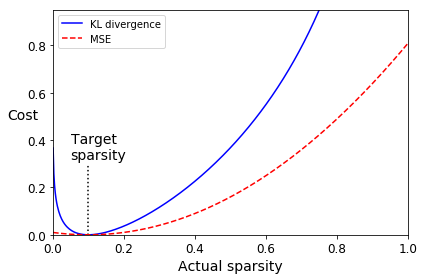

In [54]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

公式15-1：Kullback–Leibler散度

<img src='images/autoencoders/Kullback–Leibler divergence.png' >

在本例中，我们想要计算神经元在编码层被激活的目标概率p，及实际概率q（即，训练批次的平均激活度）之间的差距。所以，KL散度可以简化为公式15-2。

公式15-2：目标稀疏度p和实际稀疏度q之间的KL散度

<img src='images/autoencoders/KL divergence between the target sparsity p and the actual sparsity q.png' >

一旦计算了编码层每个神经元的稀疏度损失，我们只需要累加这些损失，然后将其结果加到成本函数中。为了控制稀疏度损伤和重建损失的相对重要性，我们可以通过一个稀疏度权重超参数来增加稀疏度损失。如果这个权重过高，模型将非常接近目标稀疏度，但是可能不能正确地重建输入，使得模型无用。相反，如果它的值过低，模型将忽略大多数稀疏性目标，并且学习不到什么有用特征。

In [55]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [56]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # not shown in the book

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # not shown
outputs = tf.layers.dense(hidden1, n_outputs)                     # not shown

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [57]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [58]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.13315204 	Sparsity loss: 0.15598294 	Total loss: 0.16434863
1 Train MSE: 0.060101468 	Sparsity loss: 0.03877146 	Total loss: 0.06785576
2 Train MSE: 0.0524878 	Sparsity loss: 0.06478515 	Total loss: 0.065444835
3 Train MSE: 0.047601074 	Sparsity loss: 0.010397203 	Total loss: 0.049680516
4 Train MSE: 0.042802855 	Sparsity loss: 0.3538871 	Total loss: 0.11358028
5 Train MSE: 0.040932737 	Sparsity loss: 0.01388924 	Total loss: 0.043710586
6 Train MSE: 0.039479308 	Sparsity loss: 0.04311932 	Total loss: 0.048103172
7 Train MSE: 0.037478052 	Sparsity loss: 0.29010892 	Total loss: 0.095499836
8 Train MSE: 0.033432372 	Sparsity loss: 0.272291 	Total loss: 0.08789057
9 Train MSE: 0.030924855 	Sparsity loss: 0.020251643 	Total loss: 0.034975182
10 Train MSE: 0.028239414 	Sparsity loss: 0.05163889 	Total loss: 0.038567193
11 Train MSE: 0.025655719 	Sparsity loss: 0.32736695 	Total loss: 0.09112911
12 Train MSE: 0.024245808 	Sparsity loss: 0.03820443 	Total loss: 0.031886693
13 Tr

一个重要的细节是，编码层激活度的值是在0到1之间（但是不等于0或者1），否则KL散度将返回NaN（Not a Number）。一个简单的解决方案是为编码层使用逻辑激活函数：
```python 
hidden1 = tf.nn.sigmoid(tf.matmul(X, weights1) + biases1)
```

一个简单的技巧可以加速收敛：我们可以选择一个具有较大梯度的重建损耗，而不是使用？MSE。通常情况下，交叉熵是一个不错的选择。为了使用它，我们必须规范输入，使得其值在0到1之间，并对输出层使用逻辑激活函数，使得输出值也在0到1之间。TensorFlow的sigmoid_cross_entropy_with_logits（）函数负责有效地将逻辑激活函数应用于输出层，并计算交叉熵：
```python
logits = tf.matmul(hidden1, weights2) + biases2)
outputs = tf.nn.sigmoid(logits)

reconstruction_loss = tf.reduce_sum(
tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits))
```

注意，在训练期间不需要输出操作（只在重建时使用）。

### 变分自动编码器 Variational Autoencoders

另一种重要的自动编码器被Diederik Kingma和Max Welling于2014年提出，并迅速成为最受欢迎的自动编码器之一：变分自动编码器。它和我们前面所讨论的所有编码器都不
同，特别之处在于：
* 它们是概率自动编码器，这就意味着即使经过训练，其输出也部分程度上决定于运气（不同于仅在训练期间使用随机性的去噪自动编码器）。
* 更重要的是，它们是生成自动编码器，意味着它们可以生成看起来像从训练样本采样的新实例。

这些特性使它们类似于RBMs（见附录E），但是更加易于训练，采样过程更快（使用RBMs，需要在采样一个新实例前，等待网络稳定到一个“热平衡”状态）。

我们来看看它们是如何工作的。图15-11（左）展示了一个变分自动编码器。当然，你可以识别出自动编码器的基本结构：一个编码器后是一个解码器（在这个例子中，它们都有两个隐藏层）。但是有一点不同：它的编码器会产生平均编码μ和标准偏差σ，而不是为给定输入直接产生一个编码。然后从平均值μ和标准偏差σ的高斯分布中随机抽取实际编码。在此之后，自动编码器只需要正常地解码采样编码。图15-11的右半部分展示了一个通过此编码器的训练实例。首先，编码器产生了μ和σ，然后编码是随机采样（注意，它不是精确位于μ中），最后这些编码被解码，并最终输出训练实例。

<img src='images/autoencoders/Variational autoencoder L, and an instance going through it R.png' >

图15-11：变分自动编码器（左），一个变分自动编码器的实例
（右）

如图15-11所示，虽然输入可能具有非常复杂的分布，变分自动编码器往往会产出一个像是从简单的高斯分布[2]中采样的编码：在训练期间，成本函数（后文将讨论）推动编码在编码空间内（也称潜在空间）逐步迁移到看起来像一个高斯点云的球面区域。一个重要的结果是，变分自动编码器在训练之后，可以很容易地生成一个新实例：仅仅从高斯分布中抽取随机编码，对其进行编码，然后调用即可！

接下来，我们来看看成本函数。它由两部分组成。首先是常规的重建损耗，推动自动编码器重现其输入（如前所述，可以使用交叉熵）。第二部分是潜在损耗，使用编码的目标分布（高斯分布）和实际分布之间的KL散度，使得自动编码器的编码看起来像是从简单的高斯分布中进行采样。数学计算比之前更加复杂，尤其是因为高斯噪音限制了传输到编码层的信息量（从而推动自动编码器学习更加有意义的特征）。幸运的是，潜在损坏可以简化为如下代码：

```python
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
tf.square(hidden3_sigma) + tf.square(hidden3_mean)
- 1 - tf.log(eps + tf.square(hidden3_sigma)))
```

一个常见的变体是训练编码器输出$γ=log（σ^2）$，而不是σ。当需要σ时，可以通过σ=exp（γ/2）计算。这使得编码器更容易**捕获不同规模的信号**，从而帮助提高收敛的速度。潜在损失最终将会比较简单：

```python
latent_loss = 0.5 * tf.reduce_sum(
tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
```

如下代码构建了如图15-11（左）所示的变分自动编码器，使用了$log（σ^2）$变体：

In [60]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 生成数字 Generate digits

Let's train the model and generate a few random digits:

In [61]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 18430.371 	Reconstruction loss: 14674.602 	Latent loss: 3755.7686
1 Train total loss: 17482.705 	Reconstruction loss: 13629.151 	Latent loss: 3853.5535
2 Train total loss: 17094.516 	Reconstruction loss: 13287.563 	Latent loss: 3806.9514
3 Train total loss: 17107.672 	Reconstruction loss: 13260.936 	Latent loss: 3846.736
4 Train total loss: 15949.732 	Reconstruction loss: 12238.789 	Latent loss: 3710.9438
5 Train total loss: 16114.381 	Reconstruction loss: 12290.441 	Latent loss: 3823.939
6 Train total loss: 15822.479 	Reconstruction loss: 11954.856 	Latent loss: 3867.6223
7 Train total loss: 15796.486 	Reconstruction loss: 12103.17 	Latent loss: 3693.317
8 Train total loss: 15994.26 	Reconstruction loss: 12128.283 	Latent loss: 3865.977
9 Train total loss: 15535.811 	Reconstruction loss: 11751.706 	Latent loss: 3784.1042
10 Train total loss: 16038.443 	Reconstruction loss: 12287.089 	Latent loss: 3751.354
11 Train total loss: 15299.629 	Reconstruction loss: 11567.3

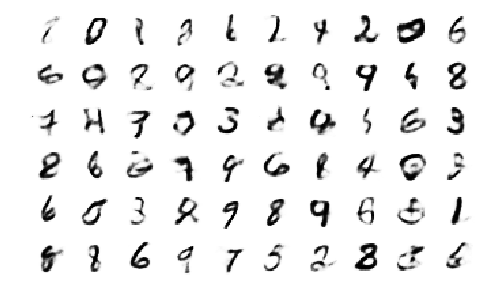

In [62]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

图15-12：变分自动编码器生成的手写数字图片

这些数字大多数看起来比较真实，有一小部分看起来相当富有“创造性”。但是这个编码器仅仅训练了一个小时，不要对它过于苛刻。训练时间长一点，生成的数字看起来会更好。

Note that the latent loss is computed differently in this second variant:

In [63]:
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

### 其他自动编码器

在图像识别、语音识别、文字翻译等方面监督学习取得了巨大的成功，有点掩盖了无监督学习，但是实际上无监督学习正在蓬勃发展的。自动编码器和其他无监督度学习算法的新框架正在不断提出，所以本书并不能完全覆盖。下面是一些你可能感兴趣的其他自动编码器的简单说明：

* 收缩自动编码器（CAE）  
该自动编码器在训练期间加入限制，使得关于输入编码的衍生物比较小。换句话说，相似的输入会得到相似的编码。
* 栈式卷积自动编码器  
该自动编码器通过卷积层重构图像来学习提取视觉特征。
* 随机生成网络（GSN）  
去噪自动编码器的推广，增加了生成数据的能力。
* 获胜者（WTA）自动编码器  
训练期间，在计算了编码层所有神经元的激活度之后，只保留训练批次中前k%的激活度，其余都置为0。自然地，这将导致稀疏编码。此外，类似的WTA方法可以用于产生稀疏卷积自动编码器。
* 对抗自动编码器  
一个网络被训练来重现输入，同时另一个网络被训练来找到不能正确重建第一个网络的输入。这促使第一个自动编码器学习鲁棒编码。

### Encode & Decode

Encode:

In [64]:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


Decode:

In [65]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


Let's plot the reconstructions:

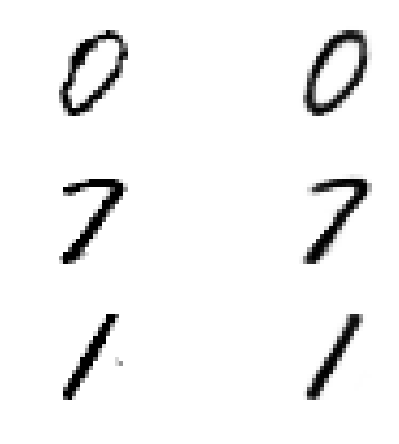

In [66]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

### Interpolate digits

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


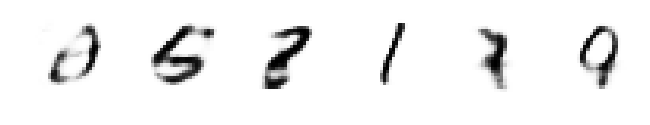

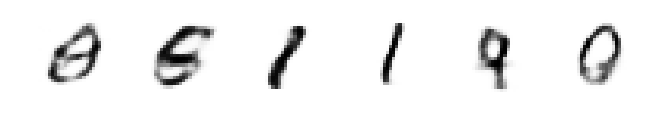

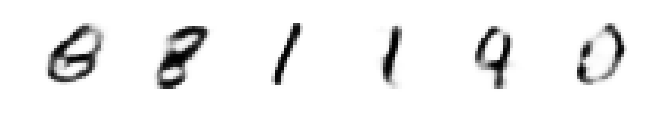

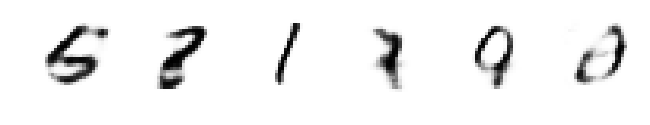

In [67]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()